Running on device: cpu


Training: 100%|██████████| 20/20 [03:22<00:00, 10.12s/it]


训练结束！


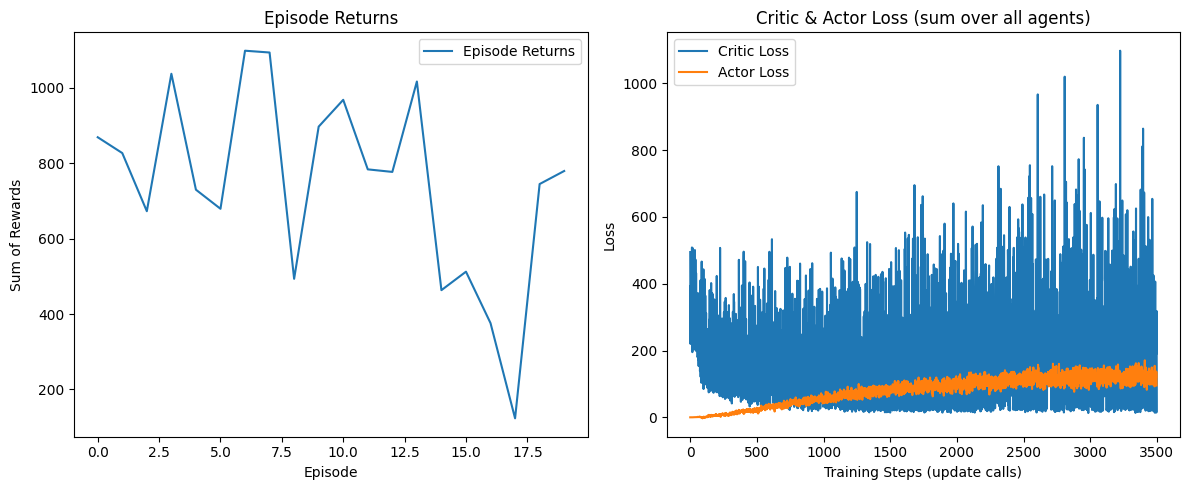

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import trange
import matplotlib.pyplot as plt

###############################################################
# 1. 你的自定义多智能体环境
###############################################################
# 假设你已经在同一个脚本/Notebook中定义好了 CustomMAEnvironment2
# 例如：
from env_new.MAenv_2 import CustomMAEnvironment2

env = CustomMAEnvironment2()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

###############################################################
# 2. 一些超参数
###############################################################
NUM_AGENTS = len(env.agents)      # 智能体数量
MAX_OBS_SIZE = env.max_obs_size   # 观测最大长度(包括自己 + 最大邻居数量)
ACTION_DIM = 2                    # 动作离散个数(本环境为0或1)
HIDDEN_DIM = 64                   # 神经网络隐藏层规模
BATCH_SIZE = 64
GAMMA = 0.95                      # 折扣因子
LR_ACTOR = 1e-3
LR_CRITIC = 1e-3
TAU = 0.01                        # 软更新参数
MEMORY_CAPACITY = 100000
EPISODES = 20                    # 训练的回合数
EPISODE_MAX_STEPS = env.num_iterations  # 与环境设置一致
UPDATE_FREQ = 1                   # 每收集 UPDATE_FREQ 步后做一次训练
WARMUP_STEPS = 500                # 在此之前不进行训练（收集经验）

###############################################################
# 3. 工具函数
###############################################################
def soft_update(target_net, source_net, tau):
    """
    软更新，将 source_net 的参数以 tau 的比例合并到 target_net 中：
    target = tau * source + (1 - tau) * target
    """
    for target_param, source_param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(
            tau * source_param.data + (1.0 - tau) * target_param.data
        )

###############################################################
# 4. 定义 Actor 和 Critic 网络结构
###############################################################
class ActorNetwork(nn.Module):
    """
    Actor：对离散动作输出一个策略分布（logits）。
    输入: obs_dim (这里用 MAX_OBS_SIZE 做统一输入，可能需要补零)
    输出: 对应 ACTION_DIM 个动作的logits
    """
    def __init__(self, input_dim, action_dim, hidden_dim=64):
        super(ActorNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, x):
        # 返回 [batch_size, action_dim] 形状的 logits
        return self.net(x)

class CriticNetwork(nn.Module):
    """
    Critic：输入为 (全局state, 所有智能体动作(拼接one-hot))，输出一个Q(s, a)。
    每个agent都有一个critic，但各自都能看到全局信息（s）和所有动作（a）。
    - state_dim: 全局state的维度
    - action_dim_total: num_agents * action_dim (离散动作one-hot拼接后长度)
    """
    def __init__(self, state_dim, action_dim_total, hidden_dim=64):
        super(CriticNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim_total, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Q值标量
        )
        
    def forward(self, s, a):
        """
        s: [batch_size, state_dim]
        a: [batch_size, action_dim_total]
        返回: [batch_size, 1]
        """
        x = torch.cat([s, a], dim=-1)  # 拼接
        return self.net(x)

###############################################################
# 5. 定义多智能体封装: MADDPGAgent
###############################################################
class MADDPGAgent:
    """
    每个agent都有自己的 (actor, critic) 和 (target_actor, target_critic)。
    Critic 输入 (全局state, 所有action)，输出该agent对应的Q值。
    """
    def __init__(self, agent_id, state_dim, obs_dim, action_dim, num_agents, hidden_dim=64):
        self.agent_id = agent_id
        self.state_dim = state_dim
        self.obs_dim = obs_dim    # 本agent输入Actor时的观测维度
        self.action_dim = action_dim
        self.num_agents = num_agents

        # Actor
        self.actor = ActorNetwork(self.obs_dim, self.action_dim, hidden_dim).to(device)
        self.target_actor = ActorNetwork(self.obs_dim, self.action_dim, hidden_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)

        # Critic
        self.critic = CriticNetwork(self.state_dim, self.num_agents * self.action_dim, hidden_dim).to(device)
        self.target_critic = CriticNetwork(self.state_dim, self.num_agents * self.action_dim, hidden_dim).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        # 初始化 target 网络参数 = 主网络参数
        soft_update(self.target_actor, self.actor, 1.0)
        soft_update(self.target_critic, self.critic, 1.0)

    def select_action(self, obs, epsilon=0.0):
        """
        根据当前观测 obs (长度为 obs_dim) 选离散动作
        这里用 epsilon-greedy：logits -> softmax -> 得到分布p，然后以p采样或随机
        """
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)  # [1, obs_dim]
        with torch.no_grad():
            logits = self.actor(obs_tensor).cpu().numpy()[0]  # [action_dim]
        # softmax
        probs = np.exp(logits - np.max(logits))
        probs = probs / np.sum(probs)
        # epsilon greedy
        if random.random() < epsilon:
            action = np.random.randint(0, self.action_dim)
        else:
            action = np.random.choice(range(self.action_dim), p=probs)
        return action

    def update(self, replay_buffer, agents, sample_size=BATCH_SIZE):
        """
        从 replay_buffer 中采样，更新本agent的 critic 和 actor。
        replay_buffer 中每条数据的结构:
            ( state, obs_n, action_n, reward_n, next_state, next_obs_n, done )
          其中 obs_n=[obs_0, ..., obs_(N-1)]， action_n=[a_0, ..., a_(N-1)]，
               next_obs_n=[nextObs_0, ..., nextObs_(N-1)]
        - agents: 所有 agent，用于获取 target_actor 等信息
        """
        if len(replay_buffer) < sample_size:
            return None, None

        batch = random.sample(replay_buffer, sample_size)
        
        # 准备批量容器
        state_batch = []
        next_state_batch = []
        obs_batch = []
        next_obs_batch = []
        action_batch = []
        reward_batch = []
        done_batch = []

        # 把所有智能体的 next_obs_n 也放进一个结构中，以便后面为每个 agent 获取其下一时刻观测
        full_next_obs_batch = []  # [batch_size, num_agents, obs_dim]

        for experience in batch:
            state, obs_n, action_n, reward_n, next_state, next_obs_n, done = experience
            # state, next_state 是全局
            state_batch.append(state)
            next_state_batch.append(next_state)
            # 取本智能体自己的 obs
            obs_batch.append(obs_n[self.agent_id])
            next_obs_batch.append(next_obs_n[self.agent_id])

            action_batch.append(action_n)
            reward_batch.append(reward_n[self.agent_id])
            done_batch.append(done)

            # 把 next_obs_n 整体放进来 (它本身是 [num_agents, obs_dim])
            full_next_obs_batch.append(next_obs_n)

        # 转成 Tensor
        state_batch      = torch.FloatTensor(state_batch).to(device)             # [batch_size, state_dim]
        next_state_batch = torch.FloatTensor(next_state_batch).to(device)        # [batch_size, state_dim]
        obs_batch        = torch.FloatTensor(obs_batch).to(device)              # [batch_size, obs_dim]
        next_obs_batch   = torch.FloatTensor(next_obs_batch).to(device)         # [batch_size, obs_dim]
        
        reward_batch     = torch.FloatTensor(reward_batch).unsqueeze(-1).to(device)  # [batch_size, 1]
        done_batch       = torch.FloatTensor(done_batch).unsqueeze(-1).to(device)    # [batch_size, 1]

        action_batch = np.array(action_batch)  # [batch_size, num_agents]
        # 把动作变成 one-hot
        action_batch_onehot = []
        for i in range(action_batch.shape[0]):
            onehots = []
            for j in range(self.num_agents):
                oh = np.zeros(self.action_dim, dtype=np.float32)
                oh[action_batch[i][j]] = 1.0
                onehots.append(oh)
            action_batch_onehot.append(np.concatenate(onehots, axis=0))
        action_batch_onehot = torch.FloatTensor(action_batch_onehot).to(device)  # [batch_size, num_agents*action_dim]

        # =========== 1. 计算 target_Q ===========
        # 需要先组装“所有智能体在 next_state 下的动作 one-hot”
        next_action_batch_onehot = []
        for b in range(len(batch)):
            tmp_action_list = []
            # full_next_obs_batch[b] 是 [num_agents, obs_dim]
            # 我们要对每个 agent 用 target_actor( next_obs[agent_i] ) 得到动作
            for agent_i, ag in enumerate(agents):
                # shape: [obs_dim]
                next_obs_i = full_next_obs_batch[b][agent_i]
                next_obs_i_tensor = torch.FloatTensor(next_obs_i).unsqueeze(0).to(device)  
                with torch.no_grad():
                    logits_other = ag.target_actor(next_obs_i_tensor).cpu().numpy()[0]
                # softmax -> 贪婪
                probs_other = np.exp(logits_other - np.max(logits_other))
                probs_other = probs_other / np.sum(probs_other)
                next_act_other = np.argmax(probs_other)
                # 转 one-hot
                oh = np.zeros(ag.action_dim, dtype=np.float32)
                oh[next_act_other] = 1.0
                tmp_action_list.append(oh)
            # 拼接
            tmp_action_list = np.concatenate(tmp_action_list, axis=0)
            next_action_batch_onehot.append(tmp_action_list)

        next_action_batch_onehot = torch.FloatTensor(next_action_batch_onehot).to(device)  
        # 计算 target Q
        with torch.no_grad():
            target_Q = self.target_critic(next_state_batch, next_action_batch_onehot)
            target_Q_value = reward_batch + (1.0 - done_batch) * GAMMA * target_Q

        # =========== 2. 更新 Critic ===========
        current_Q = self.critic(state_batch, action_batch_onehot)
        critic_loss = nn.MSELoss()(current_Q, target_Q_value)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # =========== 3. 更新 Actor ===========
        # 本 agent 的 actor 输出动作，然后其他 agent 用它们的“最新” actor 输出动作
        # 最后把这些动作拼接后喂到当前agent的 critic，做梯度上升(等价梯度下降 -Q)
        # (注：离散动作用策略梯度更准确，这里仅示例)

        # 先计算本 agent 基于 obs_batch 的动作分布
        logits = self.actor(obs_batch)  # [batch_size, action_dim]
        distribution = torch.softmax(logits, dim=-1)  # 取得概率分布(连续化近似 one-hot)

        # 构造全部 agents 动作 one-hot（其他 agent 用它们最新的 actor）
        all_agent_actions_onehot = []
        # 转为 numpy 只是为了拼接方便
        distribution_np = distribution.detach().cpu().numpy()
        
        for b in range(len(batch)):
            tmp_action_list = []
            for agent_i, ag in enumerate(agents):
                if agent_i == self.agent_id:
                    # 用当前 actor 的概率分布(连续化近似)
                    prob_vec = distribution_np[b]  # [action_dim]
                    prob_torch = torch.FloatTensor(prob_vec).to(device)
                    tmp_action_list.append(prob_torch)
                else:
                    # 其他 agent 的动作：在训练时常常用它们的旧动作(或其 actor 的贪婪选择)  
                    # 这里简单地用 replay_buffer 中已有的 action_batch[b][agent_i] 做 one-hot
                    act_j = action_batch[b][agent_i]
                    oh = np.zeros(ag.action_dim, dtype=np.float32)
                    oh[act_j] = 1.0
                    tmp_action_list.append(torch.FloatTensor(oh).to(device))
            # 拼接
            tmp_action_list = torch.cat(tmp_action_list, dim=0)  # [num_agents * action_dim]
            all_agent_actions_onehot.append(tmp_action_list.unsqueeze(0))

        all_agent_actions_onehot = torch.cat(all_agent_actions_onehot, dim=0).to(device)  # [batch_size, num_agents * action_dim]

        # 在 critic 上评估 Q
        current_Q_for_actor = self.critic(state_batch, all_agent_actions_onehot)
        # 我们要最大化 Q，等价于最小化 -Q
        actor_loss = - current_Q_for_actor.mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # =========== 4. 软更新 target 网 ===========
        soft_update(self.target_actor, self.actor, TAU)
        soft_update(self.target_critic, self.critic, TAU)

        return critic_loss.item(), actor_loss.item()

###############################################################
# 6. 构建多个智能体对象
###############################################################
# 全局state的维度
state_dim = len(env.get_state())

agents = []
for i in range(NUM_AGENTS):
    agent = MADDPGAgent(
        agent_id=i,
        state_dim=state_dim,
        obs_dim=MAX_OBS_SIZE, 
        action_dim=ACTION_DIM,
        num_agents=NUM_AGENTS,
        hidden_dim=HIDDEN_DIM
    )
    agents.append(agent)

###############################################################
# 7. 经验回放缓冲区
###############################################################
replay_buffer = deque(maxlen=MEMORY_CAPACITY)

###############################################################
# 8. 训练循环
###############################################################
returns_history = []
critic_loss_history = []
actor_loss_history = []

global_step = 0

def pad_obs(o, size=MAX_OBS_SIZE):
    """
    如果观测 o 的维度小于 MAX_OBS_SIZE，用 0 补齐
    """
    o = np.array(o, dtype=np.float32)
    if len(o) < size:
        pad_len = size - len(o)
        o = np.concatenate([o, np.zeros(pad_len, dtype=np.float32)])
    return o

for ep in trange(EPISODES, desc="Training"):
    obs_dict = env.reset()
    done = False
    step_count = 0
    episode_reward_sum = 0.0

    while not done and step_count < EPISODE_MAX_STEPS:
        # 1) 收集所有agent的观测并决定动作
        actions_dict = {}
        obs_n = []        # 当前时刻所有智能体的观测
        for i, agent_name in enumerate(env.agents):
            obs_i = pad_obs(obs_dict[agent_name])  # 补零
            action_i = agents[i].select_action(obs_i, epsilon=0.1)  # epsilon=0.1
            actions_dict[agent_name] = action_i
            obs_n.append(obs_i)

        # 2) 与环境交互
        next_obs_dict, rewards_dict, dones_dict, infos_dict = env.step(actions_dict)
        # done 判定
        done = all(dones_dict.values())

        # 全局 state
        state = env.get_state()
        next_state = env.get_state()

        # 3) 收集并存入 replay_buffer
        #    需要所有 agent 的下一时刻观测 next_obs_n
        action_n = []
        reward_n = []
        next_obs_n = []
        for i, agent_name in enumerate(env.agents):
            action_n.append(actions_dict[agent_name])
            reward_n.append(rewards_dict[agent_name])
            next_obs_n.append(pad_obs(next_obs_dict[agent_name]))

        replay_buffer.append(
            (
                state,      # 全局 state
                obs_n,      # [obs_0, obs_1, ..., obs_(N-1)]
                action_n,   # [act_0, act_1, ..., act_(N-1)]
                reward_n,   # [r_0, r_1, ..., r_(N-1)]
                next_state, # 全局 next_state
                next_obs_n, # [nextObs_0, nextObs_1, ..., nextObs_(N-1)]
                float(done)
            )
        )

        # 4) 累积奖励
        episode_reward_sum += sum(rewards_dict.values())

        obs_dict = next_obs_dict
        step_count += 1
        global_step += 1

        # 5) 训练
        if global_step > WARMUP_STEPS and global_step % UPDATE_FREQ == 0:
            total_critic_loss = 0.0
            total_actor_loss = 0.0
            for agent in agents:
                c_loss, a_loss = agent.update(replay_buffer, agents, BATCH_SIZE)
                if c_loss is not None:
                    total_critic_loss += c_loss
                if a_loss is not None:
                    total_actor_loss += a_loss
            critic_loss_history.append(total_critic_loss)
            actor_loss_history.append(total_actor_loss)

    returns_history.append(episode_reward_sum)

###############################################################
# 9. 训练结束，绘图展示
###############################################################
print("训练结束！")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Episode Returns")
plt.plot(returns_history, label='Episode Returns')
plt.xlabel("Episode")
plt.ylabel("Sum of Rewards")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Critic & Actor Loss (sum over all agents)")
plt.plot(critic_loss_history, label='Critic Loss')
plt.plot(actor_loss_history, label='Actor Loss')
plt.xlabel("Training Steps (update calls)")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()